In [1]:
from datetime import datetime
import settings.config_tourism_dataset as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
evaluation_ground_truth = cfg.evaluation_ground_truth
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'tourism_dataset'

'preprocessed_tourism_dataset'

In [2]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
len(group_composition)

79

## Prepare groundtruth

In [3]:
import pickle
import os
#from individual_rs.individual_rs import IndividualRS
from utils.utility_functions import create_per_user_group_choices,create_per_user_satisfaction

import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

print(datetime.now(), "Select ground-truth for tourism dataset")
current_fold = 0
path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

if group_types == "REAL":
    

    group_choices = pd.read_csv(preprocessed_dataset_folder+"/group_choices.csv")
    ground_truth = create_per_user_group_choices(group_composition, group_choices)
    ground_truth.columns = ['user', 'item', 'rating']    
    if not os.path.exists(path_to_fold):
        os.mkdir(path_to_fold)
    pickle.dump(ground_truth, open(path_to_fold+"/test_group_df.pkl", "wb"))
        
    group_choices = pd.read_csv(preprocessed_dataset_folder+"/group_choices.csv")
    user_feedback = pd.read_csv(preprocessed_dataset_folder+"/user_feedback.csv")
        
    ground_truth = create_per_user_satisfaction(group_composition, group_choices, user_feedback)    
    pickle.dump(ground_truth, open(path_to_fold+"/test_satisfaction_df.pkl", "wb"))

    ground_truth = ratings_df[['user', 'item', 'rating']] 
    pickle.dump(ground_truth, open(path_to_fold+"/test_ratings_df.pkl", "wb"))
    
    
    #display(ground_truth)
else:
    print("ERROR: incorrect config file!")
print(datetime.now(), "Done!")


2022-09-18 19:20:10.935811 Select ground-truth for tourism dataset
2022-09-18 19:20:12.072861 Done!


# Construct group recommendations

In [5]:
from utils.utility_functions import generate_group_recommendations_forall_groups

import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "REAL":
        test_pred_df = ratings_df[['user', 'item', 'rating']]
        test_pred_df.columns = ['user', 'item', 'predicted_rating']
    else:
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    print(datetime.now(), f+": Done")
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2022-09-18 19:20:54.833177 fold_0: Generate GRS for all the aggregation strategies and all the groups
2022-09-18 19:20:55.341209 fold_0: Done


# Evaluate group recommendations
### Define evaluation variants

In [6]:
 evaluation_variants = [
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "GROUP_CHOICES",
         "binarize_feedback": True,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "USER_RATINGS",
         "binarize_feedback_positive_threshold": 6,
         "binarize_feedback": True,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "USER_SATISFACTION",
         "binarize_feedback_positive_threshold": 3.5,
         "binarize_feedback": True,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "USER_SATISFACTION",
         "binarize_feedback_positive_threshold": 3.5,
         "binarize_feedback": False,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },     
 ]

In [8]:
import os
import time
import json
from utils.utility_functions import calculate_inverse_propensity_score,calculate_inverse_propensity_score_user_normalization
from utils.utility_functions import evaluate_group_recommendations_forall_groups

import warnings
warnings.filterwarnings('ignore')

lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "REAL":
            if cfg.evaluation_ground_truth == "GROUP_CHOICES":
                test_df = pickle.load(open(path_to_fold+"/test_group_df.pkl", "rb"))
            elif cfg.evaluation_ground_truth == "USER_SATISFACTION":
                test_df = pickle.load(open(path_to_fold+"/test_satisfaction_df.pkl", "rb"))
            else:
                test_df = pickle.load(open(path_to_fold+"/test_ratings_df.pkl", "rb"))
            #print(test_df.head())
        else:
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))

        group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        #display(ground_truth)
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold,
            cfg.evaluation_ground_truth,            
            cfg.binarize_feedback_positive_threshold,
            cfg.binarize_feedback,
            cfg.feedback_polarity_debiasing        
        )
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

2022-09-18 19:25:33.866577 fold_0: Evaluate Group recommendations
2022-09-18 19:25:37.503587 Fold Evaluation DONE
2022-09-18 19:25:37.509552 fold_0: Evaluate Group recommendations
2022-09-18 19:25:42.036587 Fold Evaluation DONE
2022-09-18 19:25:42.046598 fold_0: Evaluate Group recommendations
2022-09-18 19:25:46.422551 Fold Evaluation DONE
2022-09-18 19:25:46.435550 fold_0: Evaluate Group recommendations
2022-09-18 19:25:50.484587 Fold Evaluation DONE


# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [10]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1663521937.505588'),
 (1, 'eval_1663521942.043603'),
 (2, 'eval_1663521946.4305513'),
 (3, 'eval_1663521950.4925869')]

In [11]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

,evaluation_ground_truth,binarize_feedback,binarize_feedback_positive_threshold
eval_1663521937.505588,GROUP_CHOICES,True,3.5
eval_1663521942.043603,USER_RATINGS,True,6.0
eval_1663521946.4305513,USER_SATISFACTION,True,3.5
eval_1663521950.4925869,USER_SATISFACTION,False,3.5


# Visualize results from individual evaluation runs

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#select which evaluation run to display
res_folder = parameters_df.index[3]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [16]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]


### Depict overall (mean) results across all groups

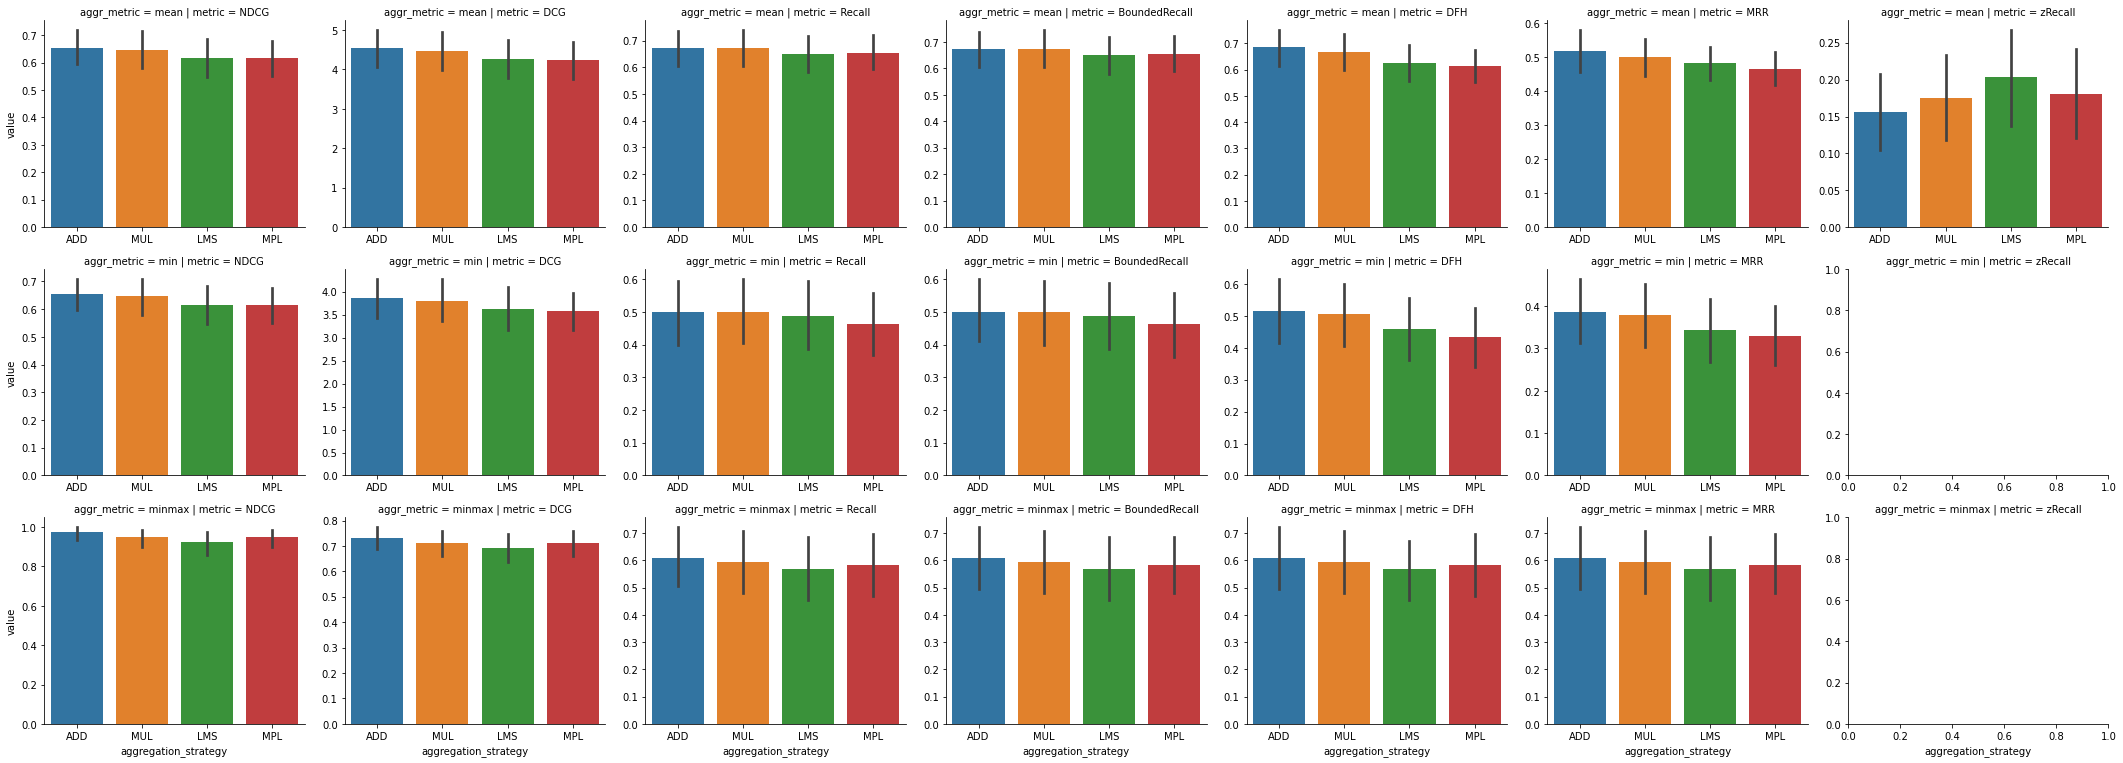

In [17]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, col="metric", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


In [18]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,mean,0.613147,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,min,0.613147,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,minmax,1.000000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,mean,4.250000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,min,3.000000,ADD,0


### Metric variance per group size; keeping the aggregation strategies visible

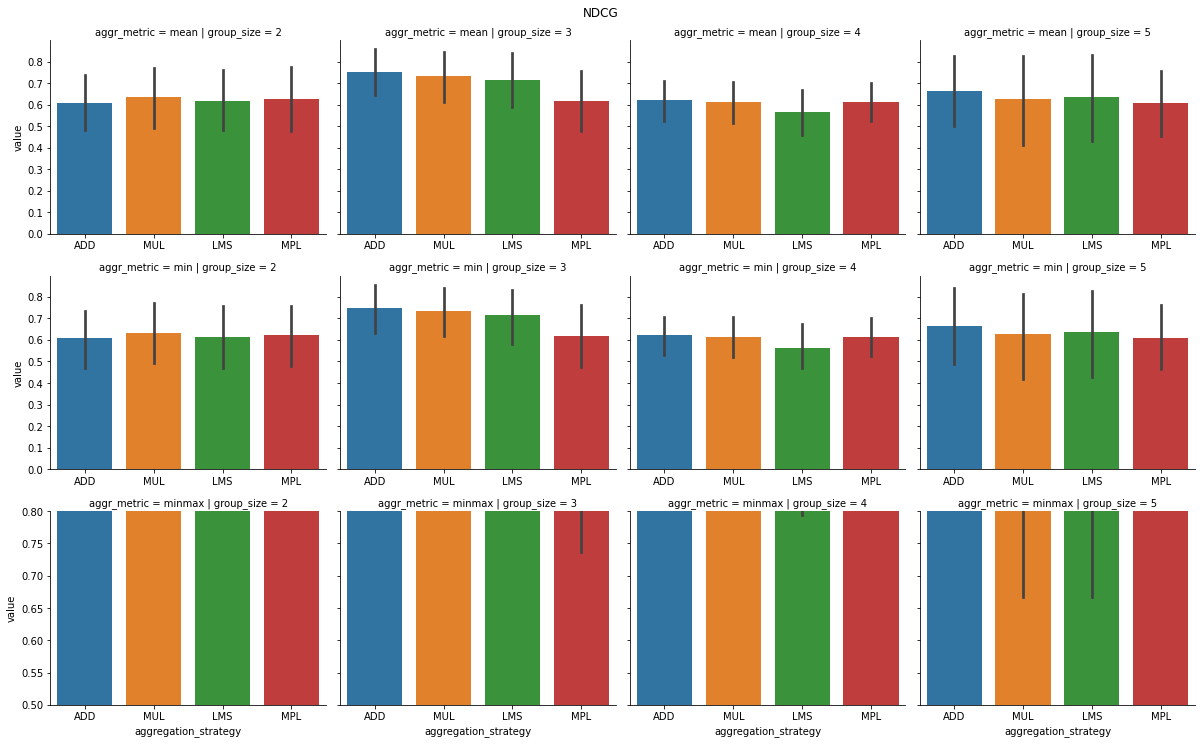

In [19]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.ylim([0.5,0.8])
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

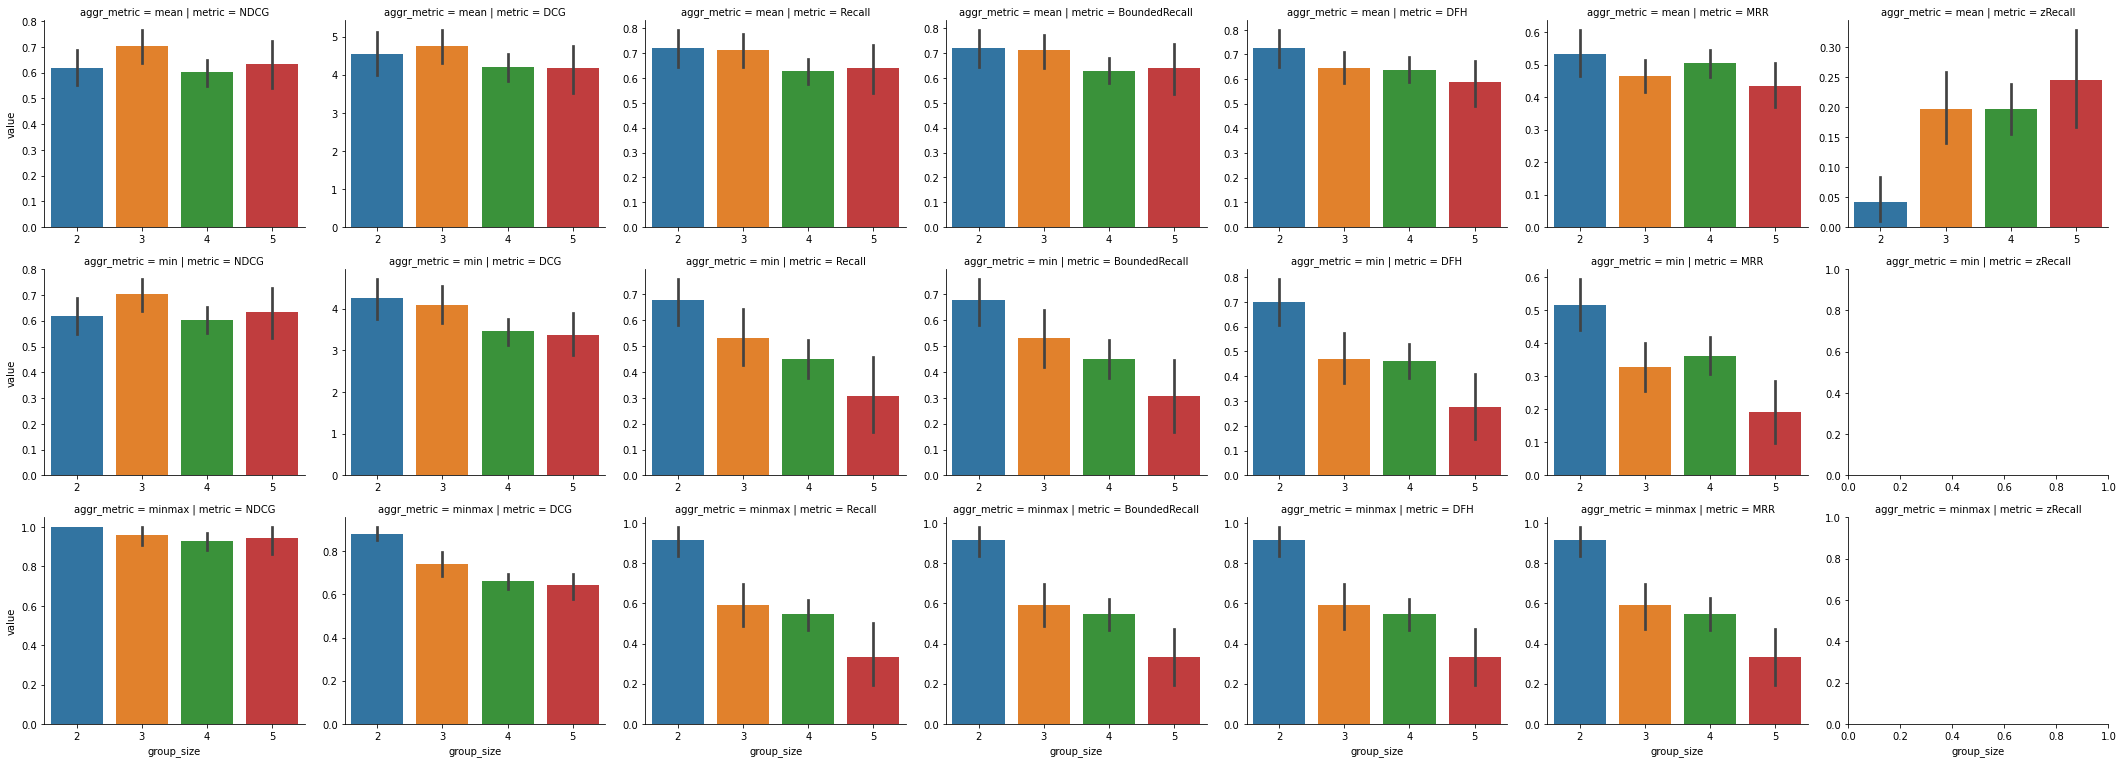

In [20]:
g = sns.catplot(data=eval_df_with_group_info, col="metric", row="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

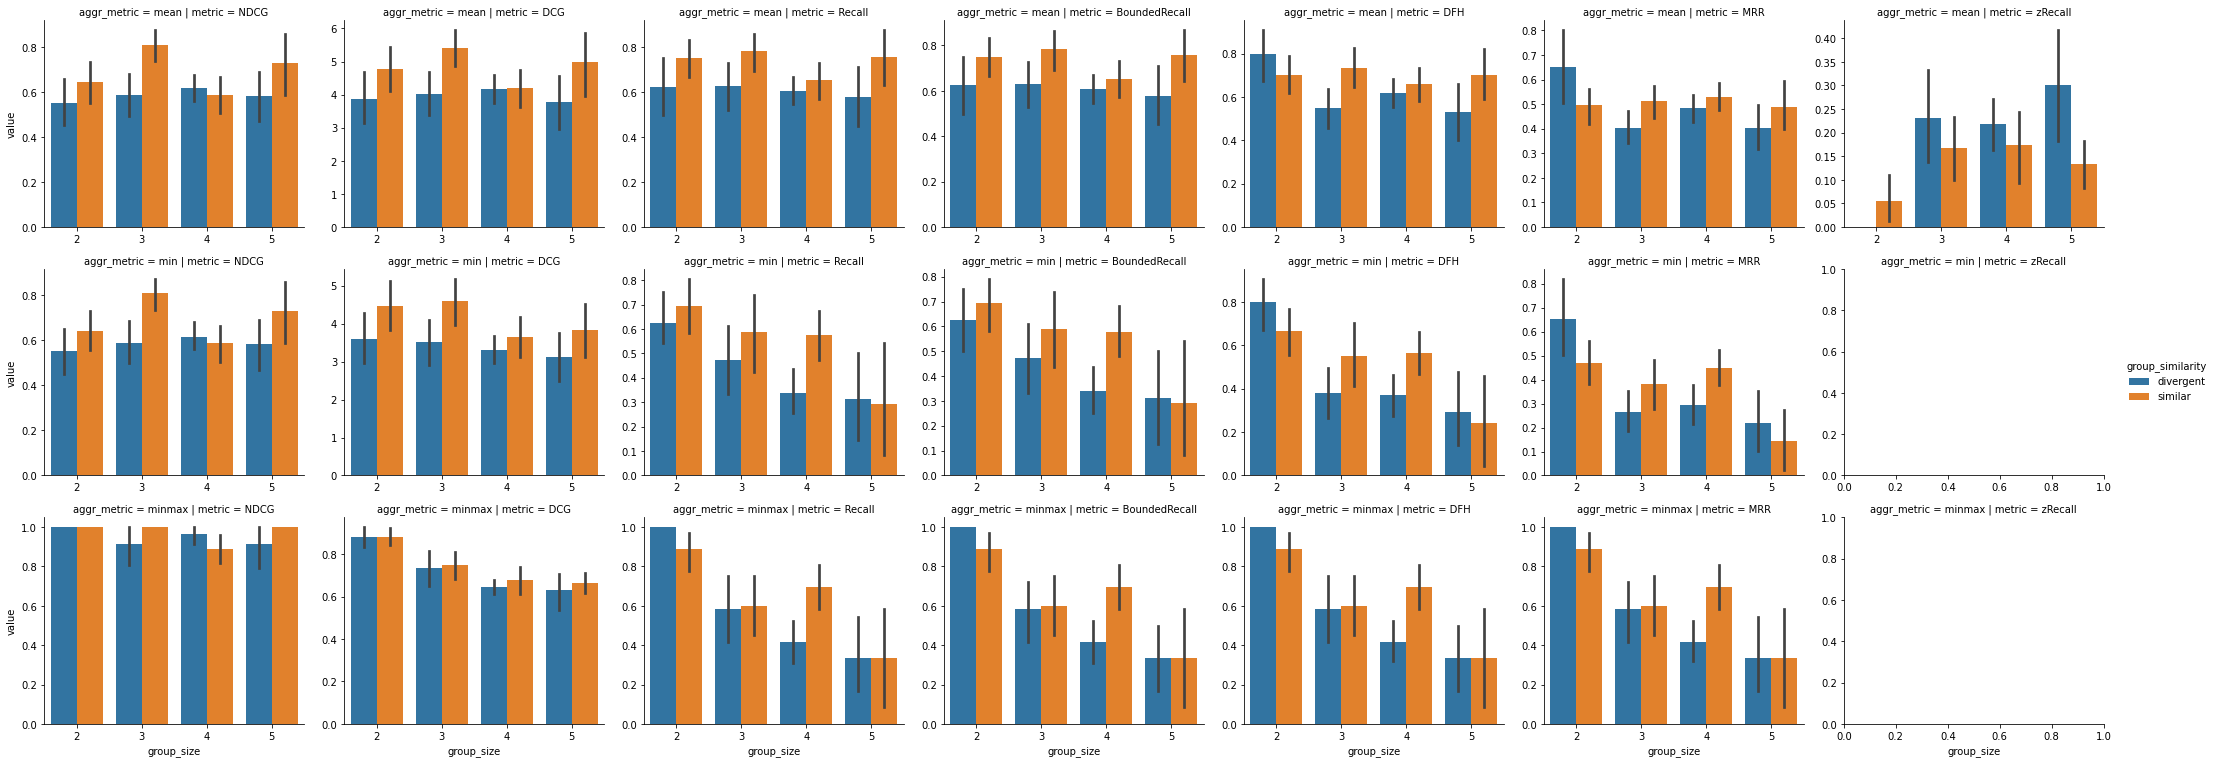

In [21]:
g = sns.catplot(data=eval_df_with_group_info, hue="group_similarity", col="metric", row="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

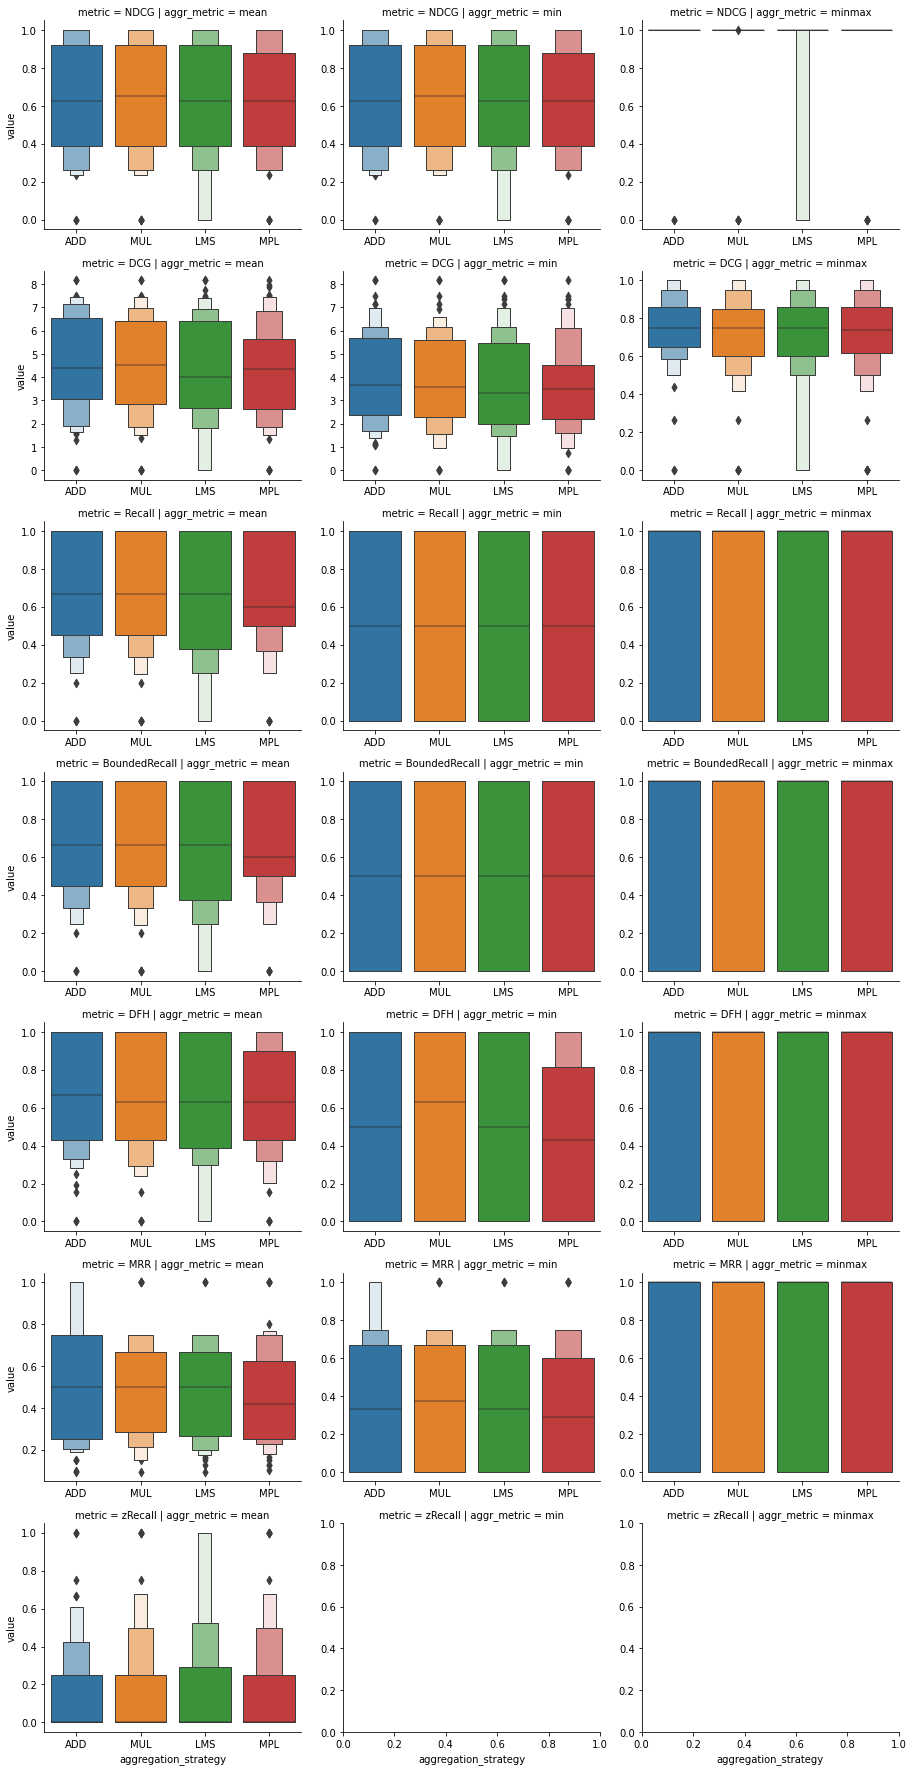

In [22]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [23]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [24]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [25]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [26]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[:]
parameters_df_relevant.loc[valid_rows]

,evaluation_ground_truth,binarize_feedback,binarize_feedback_positive_threshold
eval_1663521937.505588,GROUP_CHOICES,True,3.5
eval_1663521942.043603,USER_RATINGS,True,6.0
eval_1663521946.4305513,USER_SATISFACTION,True,3.5
eval_1663521950.4925869,USER_SATISFACTION,False,3.5


In [27]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat = eval_df_concat.loc[eval_df_concat.aggr_metric=="mean"] #GROUP CHOICES only support this one

group_composition_DF = pd.DataFrame(group_composition).T
eval_df_concat_with_group_info = group_composition_DF.join(eval_df_concat.set_index("group_id"))
eval_df_concat_with_group_info.head(3)

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold,evaluation_ground_truth,binarize_feedback,binarize_feedback_positive_threshold
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,mean,0.613147,ADD,0,GROUP_CHOICES,True,3.5
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,mean,1.000000,ADD,0,GROUP_CHOICES,True,3.5
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.500000,ADD,0,GROUP_CHOICES,True,3.5


### Comparing different ground truth definitions: individual rating / group choice / choice satisfaction

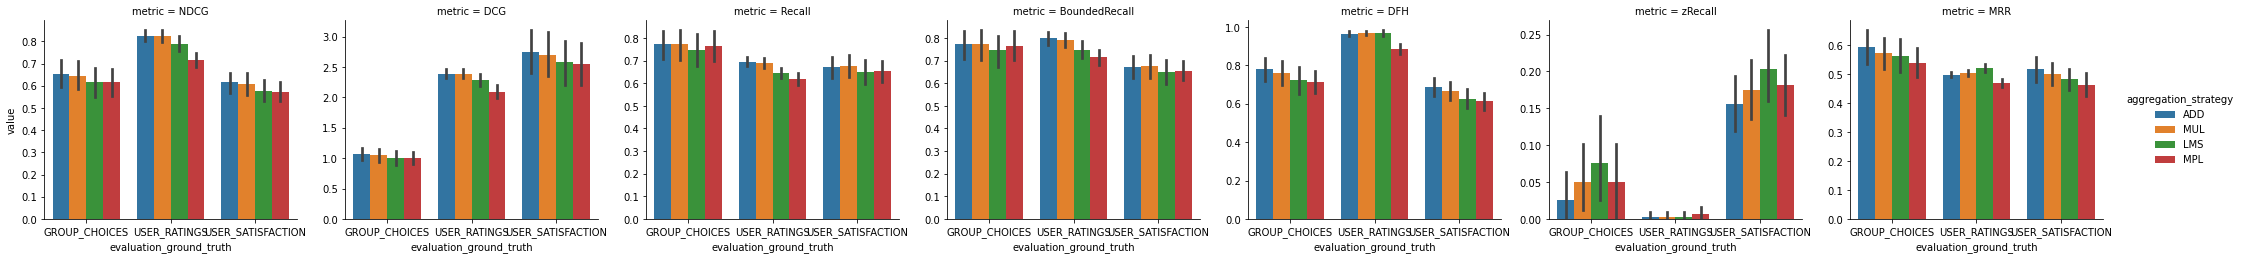

In [29]:
g = sns.catplot(data=eval_df_concat, x="evaluation_ground_truth", 
                col="metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

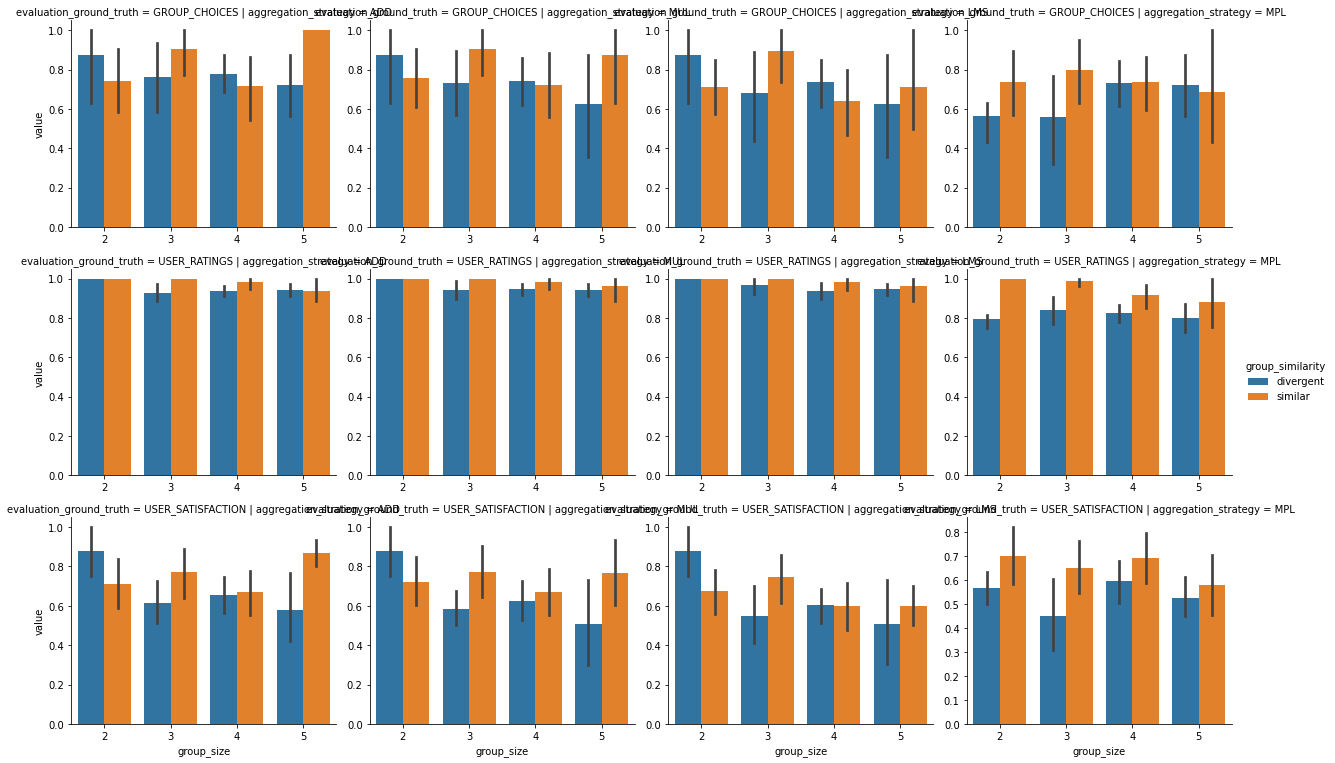

In [30]:
metric = "DFH"
g = sns.catplot(data=eval_df_concat_with_group_info.loc[eval_df_concat_with_group_info.metric==metric],  
                hue="group_similarity", x="group_size", 
                col="aggregation_strategy", row="evaluation_ground_truth", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)